# Traffic sign classification  - German Traffic Sign Data
### Pytorch Implementation

---
## Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "data/train.p"
validation_file="data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
import numpy as np

In [3]:
# Number of training examples
n_train = len(train["features"])

# Number of validation examples
n_validation = len(valid["features"])

# Number of testing examples.
n_test = len(test["features"])

# What's the shape of an traffic sign image?
image_shape = train["features"][0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.concatenate((train["labels"],test["labels"],valid["labels"]))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

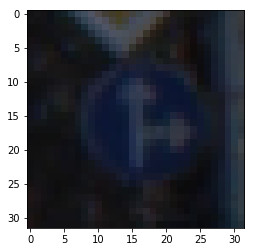

In [5]:
plt.imshow(X_train[1000])
plt.show()

(array([ 30., 240., 240., 150., 210., 210.,  60., 150., 150., 150., 210.,
        150., 210., 240.,  90.,  90.,  60., 120., 120.,  30.,  60.,  60.,
         60.,  60.,  30., 150.,  60.,  30.,  60.,  30.,  60.,  90.,  30.,
         90.,  60., 120.,  60.,  30., 210.,  30.,  60.,  30.,  30.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <a list of 43 Patch objects>)

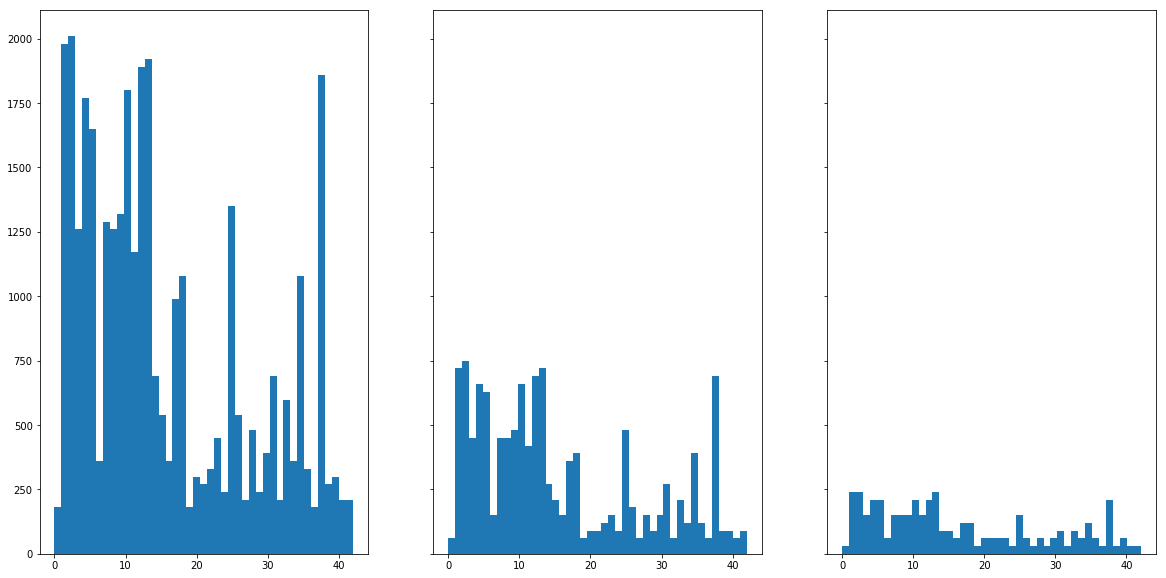

In [6]:
fig, axs = plt.subplots(1,3,figsize=(20,10),sharex=False,sharey=True)
axs[0].hist(y_train,bins=43)
axs[1].hist(y_test,bins=43)
axs[2].hist(y_valid,bins=43)

### GPU 

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device=device,dtype=None)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Pre-process the Data Set

In [26]:
from PIL import Image
import torch
import torchvision as tv

device = get_default_device()

#Data augmentation and normalization
def trainTransform(x):
    tfm = tv.transforms.Compose([tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    x = Image.fromarray(x)
    x = tfm(x)
    return x

def brightnessTransform(x):
    tfm = tv.transforms.Compose([tv.transforms.ColorJitter(0.5),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    x = Image.fromarray(x)
    x = tfm(x)
    return x

def grayTransform(x):
    tfm = tv.transforms.Compose([tv.transforms.RandomGrayscale(p=1),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    x = Image.fromarray(x)
    x = tfm(x)
    return x

def resizeTransform(x):
    tfm = tv.transforms.Compose([tv.transforms.RandomResizedCrop(32,scale=(0.07,1)),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    x = Image.fromarray(x)
    x = tfm(x)
    return x

def affineTransform(x):
    tfm = tv.transforms.Compose([tv.transforms.RandomAffine(degrees=20,scale=(0.07,1),
                                                            translate=(0.08,0.08),shear=(10,10)),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    x = Image.fromarray(x)
    x = tfm(x)
    return x
    
trainX = torch.stack([trainTransform(x) for x in X_train])
trainX_bright = torch.stack([brightnessTransform(x) for x in X_train])
trainX_gray = torch.stack([grayTransform(x) for x in X_train])
trainX_resize = torch.stack([resizeTransform(x) for x in X_train])
trainX_affine = torch.stack([affineTransform(x) for x in X_train])
testX = torch.stack([trainTransform(x) for x in X_test])
validX = torch.stack([trainTransform(x) for x in X_valid])

In [27]:
from torch.utils.data import DataLoader,TensorDataset, ConcatDataset
train_base_dataset = TensorDataset(trainX,torch.LongTensor(y_train))
train_bright_dataset = TensorDataset(trainX_bright,torch.LongTensor(y_train))
train_gray_dataset = TensorDataset(trainX_gray,torch.LongTensor(y_train))
train_resize_dataset = TensorDataset(trainX_resize,torch.LongTensor(y_train))
train_affine_dataset = TensorDataset(trainX_affine,torch.LongTensor(y_train))

train_dataset = ConcatDataset([train_base_dataset,train_bright_dataset,train_gray_dataset,
                               train_resize_dataset,train_affine_dataset])
test_dataset = TensorDataset(testX,torch.LongTensor(y_test))
valid_dataset = TensorDataset(validX,torch.LongTensor(y_valid))

#Define dataloaders
def get_train_loader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2)
    train_loader = DeviceDataLoader(train_loader,device)
    return(train_loader)

test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=len(y_test), shuffle=True,num_workers=2),device)
val_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size=len(y_valid), shuffle=True,num_workers=2),device)

### Model Architecture

In [28]:
import torch
import torch.nn.functional as F

In [43]:
class LeNet(torch.nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.relu = torch.nn.ReLU()
        
        #input shape: 32x32x3
        #Conv layer 1: Input channels = 3, output channels = 6, filter size = 5x5, stride = 1
        self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=(5,5), stride=1,padding=0)
        
        #shape:28x28x6 
        
        
        #Pool layer 1: filter size = 2x2, stride = 2
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        
        #shape: 14x14x6
        
        #Conv layer 2: Input channels = 6, output channels = 16, filter size = 5x5, stride = 1
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=(5,5), stride=1,padding=0)
        
        #shape: 10x10x16
        
        #Pool layer 2: filter size = 2x2, stride = 2
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        
        #shape: 5x5x16
        
        #self.flatten1 = torch.flatten()
        
        #Fully connected layer 1: 400 input features, 120 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(400, 120)
        self.dropout = torch.nn.Dropout(p=0.2)

        #Fully connected layer 2: 120 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(120, 84)
        #self.dropout = torch.nn.Dropout(p=0.)
        
        #Output layer: Softmax, 43 outputs
        #self.fc3 = torch.nn.Linear(120,84)
        
        self.fc3 = torch.nn.Linear(84,43)
        self.softmaxout = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = self.fc1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmaxout(x)
        return(x)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [30]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [31]:
import time
from torch.autograd import Variable

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        correct = 0
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs,labels) in enumerate(train_loader):
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs,labels)
            loss_size.backward()
            optimizer.step()
            
            #statistics
            running_loss += loss_size.data
            total_train_loss += loss_size.data
            pred = outputs.detach().max(1)[1]
            correct += pred.eq(labels.view_as(pred)).sum()
            
            #Print every epoch
            if i+1 == n_batches:
                print("Epoch {} \ntraining accuracy: {:.2f} took: {:.2f}s".format(
                    epoch+1, 100*(float(correct) / len(train_loader.dl.dataset)), time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                correct = 0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        total_correct = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data
            pred = val_outputs.detach().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()
        
        print("Validation accuracy = {:.2f}%".format(100*(float(total_correct) / len(val_loader.dl.dataset))))
        print("Validation loss = {:.2f}".format(float(total_val_loss) / len(val_loader.dl.dataset)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [44]:
CNN = LeNet()
to_device(CNN,device)
trainNet(CNN, batch_size=256, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 256
epochs= 10
learning_rate= 0.001
Epoch 1 
training accuracy: 40.62 took: 8.73s
Validation accuracy = 76.67%
Validation loss = 0.00
Epoch 2 
training accuracy: 68.37 took: 9.82s
Validation accuracy = 87.30%
Validation loss = 0.00
Epoch 3 
training accuracy: 73.18 took: 9.60s
Validation accuracy = 89.80%
Validation loss = 0.00
Epoch 4 
training accuracy: 75.54 took: 7.95s
Validation accuracy = 91.13%
Validation loss = 0.00
Epoch 5 
training accuracy: 77.14 took: 8.12s
Validation accuracy = 91.93%
Validation loss = 0.00
Epoch 6 
training accuracy: 78.34 took: 7.86s
Validation accuracy = 93.20%
Validation loss = 0.00
Epoch 7 
training accuracy: 79.32 took: 7.71s
Validation accuracy = 92.09%
Validation loss = 0.00
Epoch 8 
training accuracy: 80.03 took: 8.22s
Validation accuracy = 93.99%
Validation loss = 0.00
Epoch 9 
training accuracy: 80.67 took: 8.12s
Validation accuracy = 93.11%
Validation loss = 0.00
Epoch 10 
training accuracy: 81.17 took: 8